# Этапы проекта:
- [Подготовка данных](#cell1)
    - [Проверка эффективности обогащения](#cell1.2)
    - [Анализ признаков, недоступных в тестовой выборке](#cell1.3)
        - [Вывод](#cell1.3_)
    - [Предобработка данных](#cell1.4_)
- [Анализ данных](#cell2)
    - [Изменение концентраций Au, Ag, Pb](#cell2.1)
        - [Вывод](#cell2.1_)
    - [Сравнение размеров гранул на различных этапах очистки](#cell2.2)
        - [Вывод](#cell2.2_)
    - [Исследование концентраций веществ на разных стадиях](#cell2.3)
        - [Вывод](#cell2.3_)
- [Модель](#cell3)
    - [Создание функции для вычисления sMAPE](#cell3.1)
    - [Обучение модели](#cell3.2)
        - [Вывод](#cell3.2_)

# 1. Подготовка данных<a id="cell1"></a>

In [1]:
import pandas as pd
data_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')
data_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')

### 1.2 Проверка эффективности обогащения<a id="cell1.2"></a>

In [2]:
from sklearn.metrics import mean_absolute_error

def check_recovery(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    if F * (C - T) == 0:
        return row
    row['recovery'] = 100 * (C * (F - T) / (F * (C - T)))
    return row
    

data_check_recovery = data_train[['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]
data_check_recovery['recovery'] = pd.Series()
data_check_recovery = data_check_recovery.apply(check_recovery, axis=1).dropna()
mean_absolute_error(data_check_recovery['rougher.output.recovery'], data_check_recovery['recovery'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


9.444891926100695e-15

### 1.3 Анализ признаков, недоступных в тестовой выборке<a id="cell1.3"></a>

In [3]:
features_train = data_train.columns
features_test = data_test.columns
set(features_train) - set(features_test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Все эти признаки относятся к категориям output и calculation, т.е. для обучения модели их использовать нельзя, тк они сильно связаны с результатом
Также я заглянул слегка вперед, в тестовой выборке отсутствуют target'ы - final.output.recovery и rougher.output.recovery, нужно будет их вычленить из data_full для дальнейшей работы <a id="cell1ю3_"></a>

### 1.4 Предобработка данных<a id="cell1.4"></a>

In [4]:
data_test = data_test.fillna(method='ffill')
data_train = data_train.fillna(method='ffill')
data_full = data_full.fillna(method='ffill')
target_test = data_full.loc[data_test.index][['rougher.output.recovery', 'final.output.recovery']]

# 2. Анализ данных<a id="cell2"></a>

### 2.1 Изменение концентраций Au, Ag, Pb<a id="cell2.1"></a>
Найду последовательно для каждого металла MAE, это покажет именно динамику концентрации, тк концентрация изначально дана в процентах

In [5]:
import re
concentrations_data = data_full[re.findall('.+concentrate_[^so]{2}', '\n'.join(data_full.columns))]

for me in ['au', 'ag', 'pb']:
    buf = concentrations_data[re.findall('.+'+me, '\n'.join(concentrations_data.columns))]
    print(mean_absolute_error(buf.iloc[:,0], buf.iloc[:,1]), mean_absolute_error(buf.iloc[:,1], buf.iloc[:,2]))
    print('*'*100)

11.72689031275892 12.06672505811372
****************************************************************************************************
3.2052943794488 3.717531360446321
****************************************************************************************************
1.7415692755765406 2.6975166871637617
****************************************************************************************************


Все в принципе неплохо: концентрация золота с каждой степенью очистки возрастала в среднем на число близкое к 12 процентов. Содержание побочных продуктов также увеличивалось<a id="cell2.1_"></a>

### 2.2 Сравнение размеров гранул на различных этапах очистки<a id="cell2.2"></a>

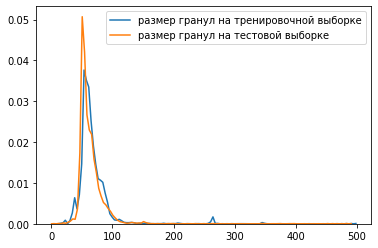

In [6]:
import seaborn as sns
sns.kdeplot(data = data_train[re.findall('.+feed_size', '\n'.join(data_train.columns))].sum(axis=1), label = 'размер гранул на тренировочной выборке')
sns.kdeplot(data = data_test[re.findall('.+feed_size', '\n'.join(data_test.columns))].sum(axis=1), label = 'размер гранул на тестовой выборке')

Хорошо видно, что распределения практически идентичны<a id="cell2.2_"></a>

### 2.3 Исследование концентраций веществ на разных стадиях<a id="cell2.3"></a>
датафрейм data_test исследовать не буду т.к. там нет исследуемого признака

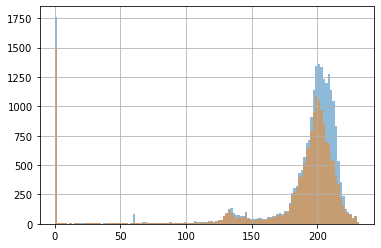

In [7]:
data_full[re.findall('.+concentrate.+', '\n'.join(data_full.columns))].sum(axis=1).hist(alpha=0.5, bins=125)
data_train[re.findall('.+concentrate.+', '\n'.join(data_train.columns))].sum(axis=1).hist(alpha=0.5, bins=125)

Виден заметный пик возле нуля, в обоих датасетах. Исследую эти значения.

In [8]:
data_full[data_full[re.findall('.+concentrate.+', '\n'.join(data_full.columns))].sum(axis=1)<1][['rougher.output.recovery', 'final.output.recovery']+re.findall('.+input.+', '\n'.join(data_full.columns))].describe()

,rougher.output.recovery,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,66.837451,66.051646,11.659499,0.690070,7.223366,0.106223,0.159038,0.056986,33.166971,48.822314,0.343033,0.128164,1.014082,0.502431,0.792861,1.539544
std,28.657888,22.683417,26.762782,2.543995,0.632403,0.494520,0.993583,0.378177,93.633079,46.142363,3.425792,0.830030,2.955486,2.278149,2.311705,1.840151
min,0.000000,0.000000,0.000003,0.000000,5.490000,0.000003,0.000000,0.000000,0.000044,5.741424,0.000000,0.000000,0.000002,0.000003,0.000014,0.000010
25%,55.007262,50.150146,0.015966,0.003255,6.850000,0.002058,0.000000,0.000000,0.118731,30.493793,0.000000,0.000000,0.003350,0.002317,0.005910,0.020993
50%,78.998992,64.053785,1.511742,0.020969,7.310000,0.004646,0.000000,0.000000,0.190870,42.127425,0.000000,0.000000,0.013283,0.005251,0.023956,0.935168
75%,89.269730,76.804550,11.147106,0.191841,7.700000,0.009137,0.000000,0.000000,0.357182,47.700631,0.000000,0.000000,0.133441,0.010223,0.068264,3.347483
max,100.000000,100.000000,274.409626,40.024582,8.600000,6.027907,9.283511,4.341246,600.234617,339.310813,43.668799,8.298831,23.748453,31.493331,28.949609,18.709478


Очевидно, что данные мусорные, не может получиться такой хороший выход при таком низкокачественном сырье.
Нужно удалить из обоих датасетов данные, близкие к нулю<a id="cell2.3_"></a>

In [9]:
for i in range(10,0,-1):    
    print(data_full[data_full[re.findall('.+concentrate.+', '\n'.join(data_full.columns))].sum(axis=1)<i/10].shape[0], i/10)

1761 1.0
1760 0.9
1760 0.8
1760 0.7
1760 0.6
1760 0.5
1759 0.4
1757 0.3
1756 0.2
1402 0.1


подходящий критерий: сумма не меньше 0.5

In [10]:
data_full = data_full[data_full[re.findall('.+concentrate.+', '\n'.join(data_full.columns))].sum(axis=1)>=0.5]
data_train = data_train[data_train[re.findall('.+concentrate.+', '\n'.join(data_train.columns))].sum(axis=1)>=0.5]

Также нужно попробовать удалить те строки из тестового датафрейма, которые я только что удалил из полного датафрейма

In [11]:
data_test = data_test.merge(target_test, left_index=True, right_index=True, how='outer')
print(data_test.shape)
data_test = data_test.loc[(set(data_full.index) - set(data_train.index))]
print(data_test.shape)

(5856, 54)
(5594, 54)


Результат налицо

# 3. Модель<a id="cell3"></a>

### 3.1 Создание функции для вычисления sMAPE<a id="cell3.1"></a>

In [12]:
def sMAPE(prediction=[0], target=[0]):
    an=0
    k = 0
    for i in range(len(prediction)):
        y_p = prediction[i]
        y_t = target[i]
        if y_p==0 and y_t==0:
            continue
        an += (200 / (len(prediction)) ) * abs(y_t - y_p) / (abs(y_t) + abs(y_p))
    return an
print(sMAPE(data_full['rougher.output.recovery'], [data_full['rougher.output.recovery'].median()]*data_full.shape[0]))

11.997470090606875


### 3.2 Обучение модели<a id="cell3.2"></a>

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


smape_ = make_scorer(mean_absolute_error)
data_train = data_train[set(data_train.columns) & set(data_test.columns)]
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).reset_index(drop=True)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).reset_index(drop=True)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

#### Сравнение эффективностей двух подходов: предсказание пары таргетов, предсказание каждого таргета по отдельности, предсказание каждого таргета по очереди с использованием простейших моделей (линейная регрессия и дерево решений)

Предсказание сразу двух признаков

In [14]:
model_tree = DecisionTreeRegressor()
print(cross_validate(model_tree, features_train, target_train, scoring=smape_)['test_score'])
model_tree.fit(features_train, target_train)
prediction = model_tree.predict(features_test)
print(sMAPE(prediction[0], target_train.iloc[:,0])*0.25 + 0.75 * sMAPE(prediction[1], target_train.iloc[:,1]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[14.88448397 14.83019322 17.81311289]
106.69678237946434


In [15]:
model_linear = LinearRegression()
print(cross_validate(model_linear, features_train, target_train, scoring=smape_)['test_score'])
model_linear.fit(features_train, target_train)
prediction = model_linear.predict(features_test)
print(sMAPE(prediction[0], target_train.iloc[:,0])*0.25 + 0.75 * sMAPE(prediction[1], target_train.iloc[:,1]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[10.34679768 11.55132522 12.46476245]
200.0


Предсказание признаков по отдельности

In [16]:
pr = []
model_tree = DecisionTreeRegressor()
for title in ['rougher.output.recovery', 'final.output.recovery']:
    print('*'*50, title, '*'*50)
    print(cross_validate(model_tree, features_train, target_train[title], scoring=smape_)['test_score'])
    model_tree.fit(features_train, target_train[title])
    prediction = model_tree.predict(features_test)
    print(sMAPE(prediction, target_train[title]))
    pr.append(sMAPE(prediction, target_train[title]))
print('*'*100)
print(pr[0]*0.25 + 0.75 * pr[1])

************************************************** rougher.output.recovery **************************************************


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[33.09569036 12.5720746  17.57313165]
26.1771591244101
************************************************** final.output.recovery **************************************************


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[19.86153369 12.5004749  21.30445092]
13.443810470715311
****************************************************************************************************
16.627147634139007


In [17]:
pr = []
model_linear = LinearRegression()
for title in ['rougher.output.recovery', 'final.output.recovery']:
    print('*'*50, title, '*'*50)
    print(cross_validate(model_linear, features_train, target_train[title], scoring=smape_)['test_score'])
    model_linear.fit(features_train, target_train[title])
    prediction = model_linear.predict(features_test)
    print(sMAPE(prediction, target_train[title]))
    pr.append(sMAPE(prediction, target_train[title]))
print('*'*100)
print(pr[0]*0.25 + 0.75 * pr[1])

************************************************** rougher.output.recovery **************************************************


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[12.49076985 13.38200002 12.13956301]
199.9999999999848
************************************************** final.output.recovery **************************************************


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[ 8.20282551  9.72065042 12.78996189]
199.97638914329707
****************************************************************************************************
199.982291857469


Последовательное обучение 

In [18]:
scrs = []
model_tree = DecisionTreeRegressor()
model_tree.fit(features_train, target_train['rougher.output.recovery'])
prediction = model_tree.predict(features_test)
print(sMAPE(prediction, target_test['rougher.output.recovery']))
scrs.append(sMAPE(prediction, target_test['rougher.output.recovery']))

features_train_added = features_train.copy()
features_test_added = features_test.copy()
features_train_added['rougher.output.recovery'] = target_train['rougher.output.recovery']
features_test_added['rougher.output.recovery'] = prediction

model_tree.fit(features_train_added, target_train['final.output.recovery'])
prediction = model_tree.predict(features_test_added)
print(sMAPE(prediction, target_test['final.output.recovery']))
scrs.append(sMAPE(prediction, target_test['final.output.recovery']))
print(scrs[0]*0.25 + scrs[1]*0.75)

20.53110595946745
75.80268188314243
61.98478790222368


In [19]:
scrs = []
model_linear = LinearRegression()
model_tree = DecisionTreeRegressor()
model_tree.fit(features_train, target_train['rougher.output.recovery'])
prediction = model_tree.predict(features_test)
print(sMAPE(prediction, target_test['rougher.output.recovery']))
scrs.append(sMAPE(prediction, target_test['rougher.output.recovery']))

features_train_added = features_train.copy()
features_test_added = features_test.copy()
features_train_added['rougher.output.recovery'] = target_train['rougher.output.recovery']
features_test_added['rougher.output.recovery'] = prediction

model_linear.fit(features_train_added, target_train['final.output.recovery'])
prediction = model_linear.predict(features_test_added)
print(sMAPE(prediction, target_test['final.output.recovery']))
scrs.append(sMAPE(prediction, target_test['final.output.recovery']))
print(scrs[0]*0.25 + scrs[1]*0.75)

20.422436816437635
199.94793071106037
155.06655723740468


### Вывод: лучше всего проводить последовательную проверку, используя модели, в своей основе имеющие дерево решений
p.s. в последней ячейке я использовал сочетание, а не как раньше (оба раза -- линейную модель), поскольку я уже заметил, что дерево решений дает лучший результат, но я надеялся, что между столбцом rougher.output.recovery и столбцом final.output.recovery обнаружится сильная линейная зависимость, благодаря которой линейная регрессия даст лучший результат. Увы, мои надежды не оправдались

## Финальный выбор модели

In [20]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(verbose=False)
scrs = []

model_cat.fit(features_train, target_train['rougher.output.recovery'])
prediction = model_cat.predict(features_test)
print(sMAPE(prediction, target_test['rougher.output.recovery']))
scrs.append(sMAPE(prediction, target_test['rougher.output.recovery']))

features_train_added = features_train.copy()
features_test_added = features_test.copy()
features_train_added['rougher.output.recovery'] = target_train['rougher.output.recovery']
features_test_added['rougher.output.recovery'] = prediction

model_cat.fit(features_train_added, target_train['final.output.recovery'])
prediction = model_cat.predict(features_test_added)
print(sMAPE(prediction, target_test['final.output.recovery']))
scrs.append(sMAPE(prediction, target_test['final.output.recovery']))
print(scrs[0]*0.25 + scrs[1]*0.75)

11.022766860964824
11.821574034901472
11.621872241417309


## Вывод:
Лучший результат показала модель CatBoost, с предсказанием признаков в две итерации.
Далее я бы загрузил обе модели (их же 2: первая, обученная на features_train, и вторая, обученная на features_train + target_train['rougher.output.recovery'] с помощью joblib, и написал бы подробную инструкцию, но не хочется засорять мусором свой компьютер <a id="cell3.2_"></a>